<a href="https://colab.research.google.com/github/omareyoussef/456project/blob/main/CECS456_Project_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing Kaggle API
!pip install kaggle

from google.colab import files
files.upload()  # Select the animals10-metadata.json file.

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alessiocorrado99/animals10

!unzip animals10.zip -d animals10

Streaming output truncated to the last 5000 lines.
  inflating: animals10/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: animals10/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: animals10/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: animals10/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MhRGx7d8

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.
{'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
{0: 'dog', 1: 'horse', 2: 'elephant', 3: 'butterfly', 4: 'chicken', 5: 'cat', 6: 'cow', 7: 'sheep', 8: 'spider', 9: 'squirrel'}


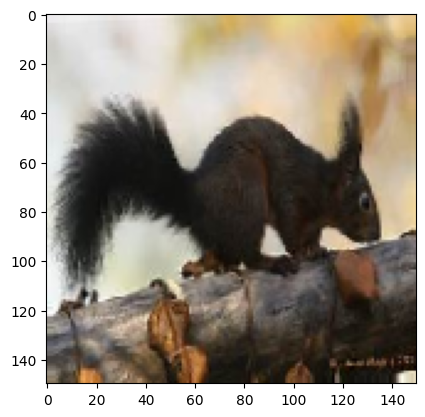

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

base_dir = 'animals10/raw-img'

# Defining ImageDataGenerator for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the images
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# class indices
print(train_generator.class_indices)

index_to_class = {v: k for k, v in train_generator.class_indices.items()}

animal_mapping = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

# map Italian names to English names
index_to_class_english = {i: animal_mapping[italian_name] for i, italian_name in index_to_class.items()}
print(index_to_class_english)

# display sample image
for images, labels in train_generator:
    plt.imshow(images[0])
    plt.show()
    break

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
654/654 [==============================] - 187s 275ms/step - loss: 1.8596 - accuracy: 0.3493 - val_loss: 1.4937 - val_accuracy: 0.4770
Epoch 2/10
654/654 [==============================] - 165s 253ms/step - loss: 1.4524 - accuracy: 0.5040 - val_loss: 1.2904 - val_accuracy: 0.5516
Epoch 3/10
654/654 [==============================] - 175s 268ms/step - loss: 1.2364 - accuracy: 0.5802 - val_loss: 1.0997 - val_accuracy: 0.6346
Epoch 4/10
654/654 [==============================] - 166s 254ms/step - loss: 1.0784 - accuracy: 0.6328 - val_loss: 1.0918 - val_accuracy: 0.6313
Epoch 5/10
654/654 [==============================] - 177s 270ms/step - loss: 0.9459 - accuracy: 0.6782 - val_loss: 0.9962 - val_accuracy: 0.6727
Epoch 6/10
654/654 [==============================] - 176s 270ms/step - loss: 0.8235 - accuracy: 0.7228 - val_loss: 1.0105 - val_accuracy: 0.6645
Epoch 7/10
654/654 [==============================] - 166s 253ms/step - loss: 0.7264 - accuracy: 0.7539 - val_loss: 1.0178 -

819/819 [==============================] - 41s 50ms/step - loss: 0.3799 - accuracy: 0.8911
Test accuracy: 89.11%
1/1 [==============================] - 0s 123ms/step


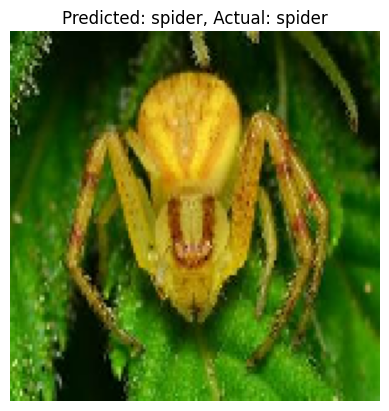

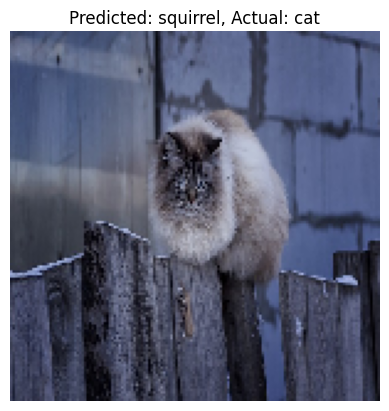

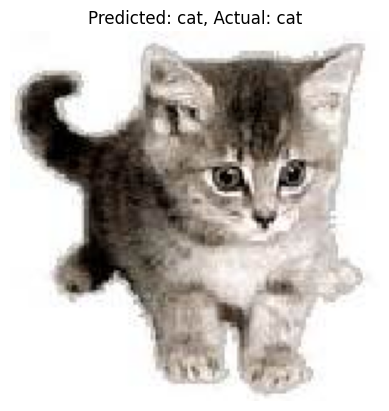

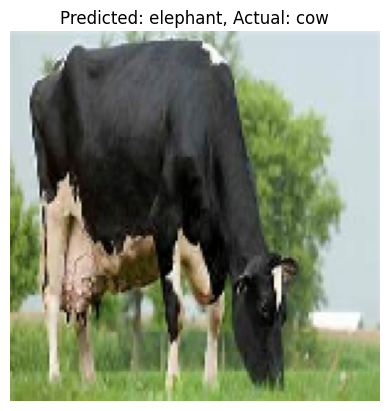

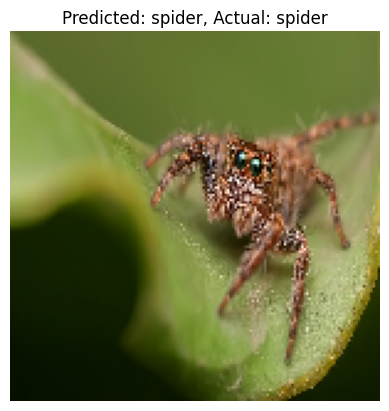

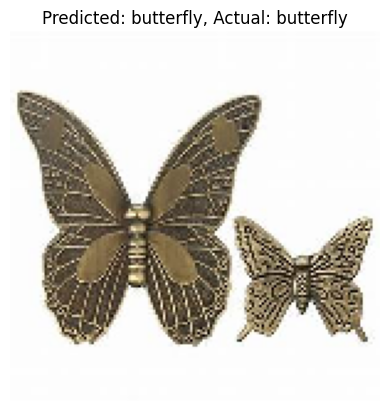

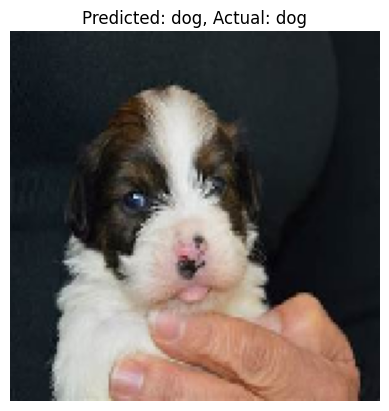

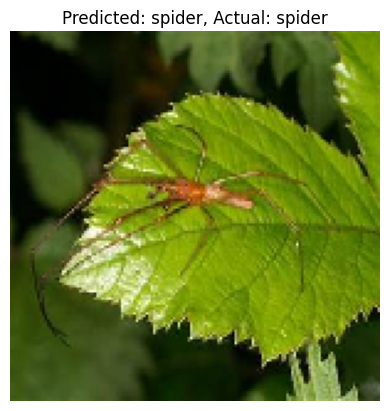

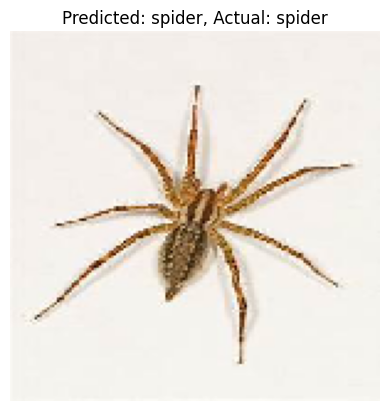

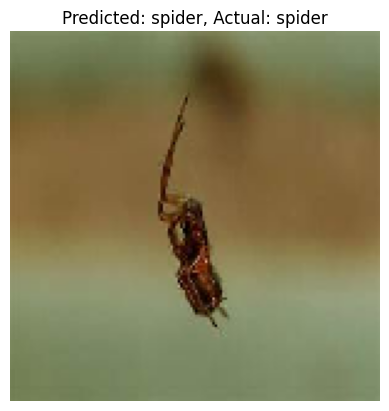

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2%}")

test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
actual_labels = tf.argmax(test_labels, axis=1).numpy()

index_to_class_english = {v: k for k, v in train_generator.class_indices.items()}

predicted_class_names = [animal_mapping[index_to_class[label]] for label in predicted_labels]
actual_class_names = [animal_mapping[index_to_class[label]] for label in actual_labels]

for i in range(10):
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {predicted_class_names[i]}, Actual: {actual_class_names[i]}")
    plt.axis('off')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


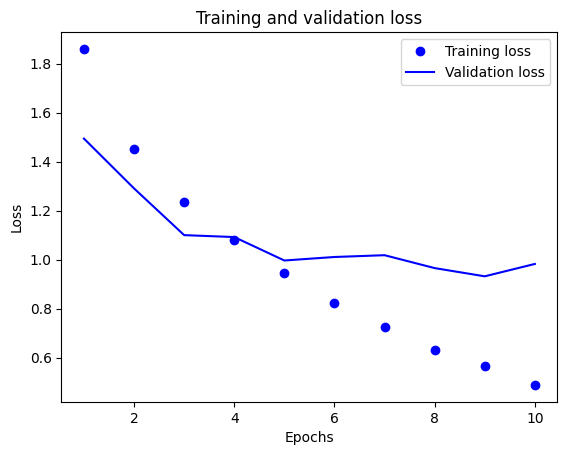

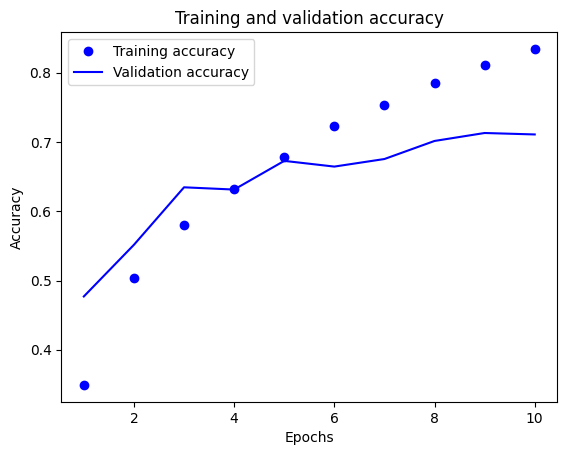

In [8]:
history_dict = history.history
print(history_dict.keys())

# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plotting the training and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2%}")


819/819 [==============================] - 40s 48ms/step - loss: 0.3799 - accuracy: 0.8911
Test accuracy: 89.11%
